In [1]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
import time
from torchsummary import summary
from torch.optim import lr_scheduler
import copy

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image
from collections import OrderedDict
import shutil

In [2]:
# Load the Data
data_dir = './data/tiny-imagenet-200'
num_classes = 200

# Create the training data generator
batch_size = 500
im_height = 64
im_width = 64

data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0, 0, 0), tuple(np.sqrt((255, 255, 255)))),
])

# Load Data from folders
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=data_transforms),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=data_transforms),
    'test': datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=data_transforms)
}

phases = ['train', 'val', 'test']

dataloaders = {'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True),
              'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=True),
              'test': DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False)}
dataset_sizes = {x: len(image_datasets[x]) for x in phases}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(dataloaders['train'])
print(dataset_sizes)

{'train': 100000, 'val': 9999, 'test': 10000}


In [25]:
def plot_result(x_scale, tr, val, title, y_label, ax=plt):
    ax.set_title(title)
    if title == 'loss':
        ax.plot(x_scale, tr, label='training loss')
        ax.plot(x_scale, val, label='validation loss')
    else:
        ax.plot(x_scale, tr, label='training accuracy')
        ax.plot(x_scale, val, label='validation accuracy')
    ax.set_xlabel("Epochs")
    ax.set_ylabel(y_label)
    ax.legend()

def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=10, verbose=True):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    tr_acc, val_acc = [], []
    tr_loss, val_loss  = [], []
    
    for epoch in range(num_epochs):
        if verbose:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1), end=": ")
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
                if phase == 'train':
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                tr_acc.append(epoch_acc)
                tr_loss.append(epoch_loss)
            elif phase == 'val':
                val_acc.append(epoch_acc)
                val_loss.append(epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        if verbose:        
            print('Training Loss: {:.4f}, Acc: {:.4f}; Validation Loss: {:.4f}, Acc: {:.4f}'.format(
                tr_loss[-1], tr_acc[-1], val_loss[-1], val_acc[-1]))

    time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(
#         time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, tr_acc, val_acc, tr_loss, val_loss

In [4]:
import resnet_modified
import importlib

In [11]:
importlib.reload(resnet_modified)
model = resnet_modified.resnet152(pretrained=False, num_classes=200, decay_factor=0.1)

# Convert model to be used on GPU
model = model.to(device)

model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): BundledBottleneck(
    (layers): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
         

learning rate: 1.1521575887987978e-05, decay_factor: 0.04628862455273426, batch_size: 64 --> Best val Acc: 0.628563


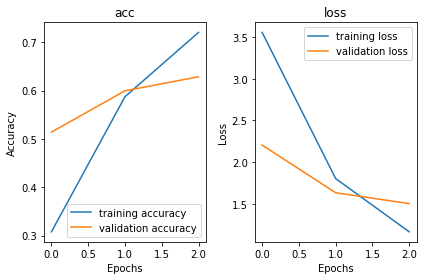

learning rate: 0.00032692705710881314, decay_factor: 0.006802565462285859, batch_size: 64 --> Best val Acc: 0.513451


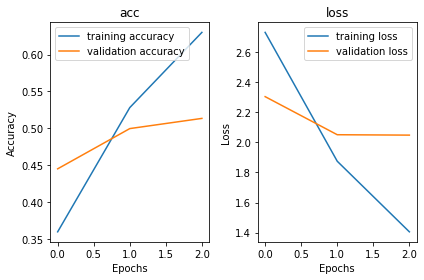

learning rate: 1.3645081411786406e-05, decay_factor: 0.1972102850562667, batch_size: 64 --> Best val Acc: 0.543154


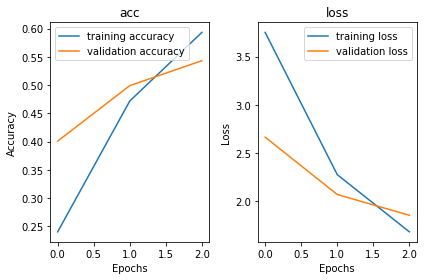

learning rate: 0.00019534097320922136, decay_factor: 0.008852083378332631, batch_size: 32 --> Best val Acc: 0.530753


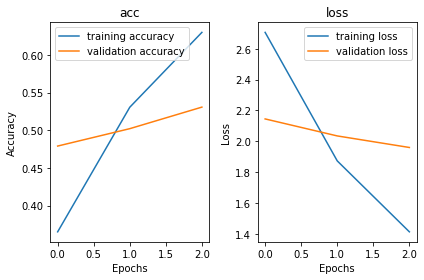

learning rate: 0.0006173922240459628, decay_factor: 0.10651360454104578, batch_size: 64 --> Best val Acc: 0.462746


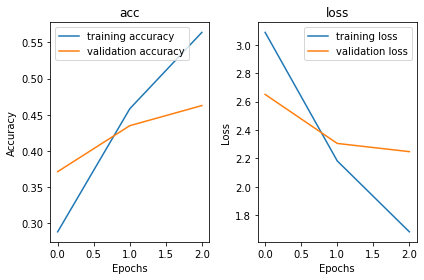

learning rate: 2.6891823885422735e-05, decay_factor: 0.08752198127601252, batch_size: 128 --> Best val Acc: 0.614661


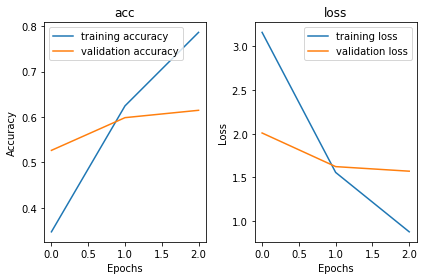

learning rate: 2.0465362996555423e-05, decay_factor: 0.19446244640764887, batch_size: 64 --> Best val Acc: 0.565257


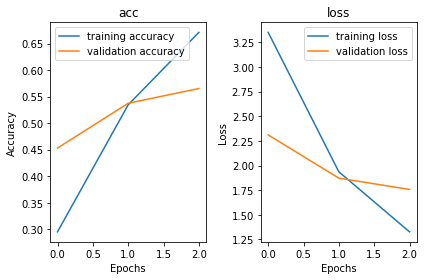

learning rate: 4.011268640762145e-05, decay_factor: 0.04145115951177836, batch_size: 128 --> Best val Acc: 0.638964


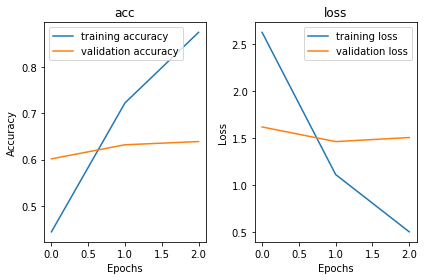

learning rate: 0.0004288217215501294, decay_factor: 0.0030719312272478928, batch_size: 32 --> Best val Acc: 0.417642


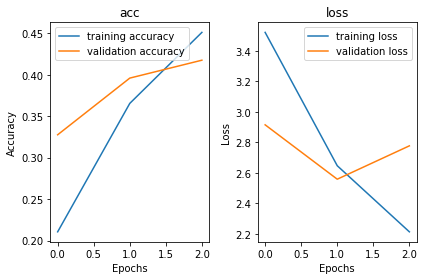

learning rate: 5.1248213428018946e-05, decay_factor: 0.139905310937775, batch_size: 32 --> Best val Acc: 0.576858


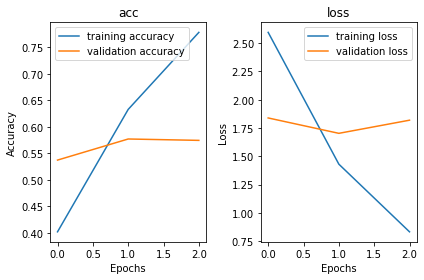

learning rate: 0.0003094316222939301, decay_factor: 0.11199001237900941, batch_size: 32 --> Best val Acc: 0.503950


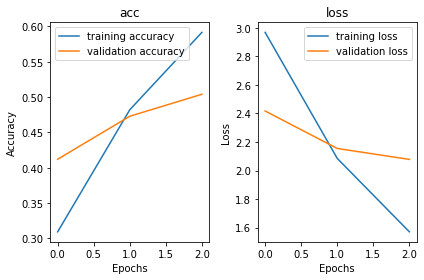

learning rate: 4.488141658739866e-05, decay_factor: 0.1916875553947117, batch_size: 64 --> Best val Acc: 0.570557


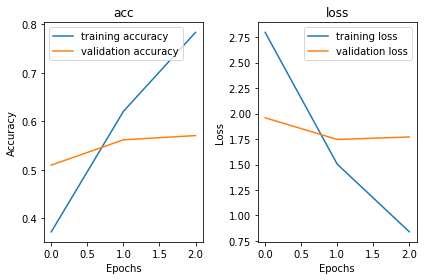

learning rate: 2.531989270420591e-05, decay_factor: 0.040628139576316925, batch_size: 32 --> Best val Acc: 0.638464


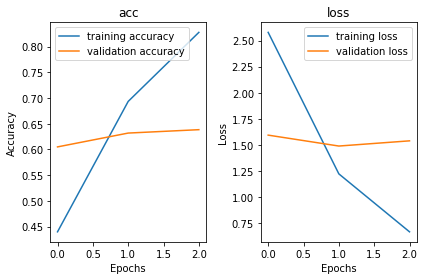

learning rate: 0.0006020535725273931, decay_factor: 0.16764568507878413, batch_size: 64 --> Best val Acc: 0.473747


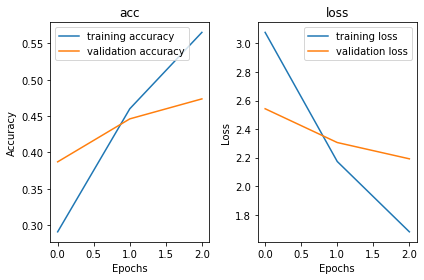

learning rate: 0.00013775101099174327, decay_factor: 0.10062663599495786, batch_size: 128 --> 

In [ ]:
# Fine tune the whole layers
max_acc = 0
results = []

for _ in range(15):
    lr = np.exp(np.random.uniform(np.log(1e-5), np.log(1e-3)))  # Uniform on a log scale between 1e-5 and 1e-3
    decay_factor = np.random.uniform(0, 0.2)
    batch_size = [32, 64, 128][np.random.randint(0, 3)]
    
    print("learning rate: {}, decay_factor: {}, batch_size: {}".format(lr, decay_factor, batch_size), end=" --> ")
    model = resnet_modified.resnet152(pretrained=True, decay_factor=decay_factor)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)
    
    dataloaders = {'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True),
              'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=True)}
                   
    model, tr_acc, val_acc, tr_loss, val_loss = train_model(model, criterion, optimizer_ft, scheduler, dataloaders, 
                                                            num_epochs=3, verbose=False)
    if max(val_acc) > max_acc:
        best_model = model
        max_acc = max(val_acc)
    results.append((lr, decay_factor, tr_acc, val_acc, tr_loss, val_loss))

    fig, (ax1, ax2) = plt.subplots(1, 2)
    plot_result(range(3), tr_acc, val_acc, 'acc', 'Accuracy', ax=ax1)
    plot_result(range(3), tr_loss, val_loss, 'loss', 'Loss', ax=ax2)
    fig.tight_layout()
    plt.show()

torch.save(best_model.state_dict(), './models/resnet152_best_model_state_dict.pth')
print("best validation accuracy", max_acc)
print(results)

print("Results:")
for x in results:
    print(x)

In [21]:
best_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): BundledBottleneck(
    (layers): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
         

In [22]:
results

[(1.1521575887987978e-05,
  0.04628862455273426,
  [tensor(0.3079, device='cuda:0', dtype=torch.float64),
   tensor(0.5873, device='cuda:0', dtype=torch.float64),
   tensor(0.7203, device='cuda:0', dtype=torch.float64)],
  [tensor(0.5141, device='cuda:0', dtype=torch.float64),
   tensor(0.5996, device='cuda:0', dtype=torch.float64),
   tensor(0.6286, device='cuda:0', dtype=torch.float64)],
  [3.557904146118164, 1.802632278404236, 1.1631593813323975],
  [2.20534763239374, 1.6323150311938428, 1.5022120479703343]),
 (0.00032692705710881314,
  0.006802565462285859,
  [tensor(0.3598, device='cuda:0', dtype=torch.float64),
   tensor(0.5281, device='cuda:0', dtype=torch.float64),
   tensor(0.6300, device='cuda:0', dtype=torch.float64)],
  [tensor(0.4451, device='cuda:0', dtype=torch.float64),
   tensor(0.4996, device='cuda:0', dtype=torch.float64),
   tensor(0.5135, device='cuda:0', dtype=torch.float64)],
  [2.731142522354126, 1.8745633629226686, 1.4054732905197143],
  [2.303985557349661, 2.0

In [23]:
np.save('hyperparameter_tuning.npy', results)

In [ ]:
lr = 2.61e-5
decay_factor = 0.04278
batch_size = 128
model = best_model

print("learning rate: {}, decay_factor: {}, batch_size: {}".format(lr, decay_factor, batch_size))

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)

dataloaders = {'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True),
          'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=True)}

model, tr_acc, val_acc, tr_loss, val_loss = train_model(model, criterion, optimizer_ft, scheduler, dataloaders, 
                                                        num_epochs=10, verbose=True)
if max(val_acc) > max_acc:
    best_model = model
    max_acc = max(val_acc)
    
torch.save(model.state_dict(), './models/resnet152_best_model_state_dict_v2.pth')
np.save('full_training.npy', np.array([lr, decay_factor, batch_size, tr_acc, val_acc, tr_loss, val_loss]))

fig, (ax1, ax2) = plt.subplots(1, 2)
plot_result(range(10), tr_acc, val_acc, 'acc', 'Accuracy', ax=ax1)
plot_result(range(10), tr_loss, val_loss, 'loss', 'Loss', ax=ax2)
fig.tight_layout()
plt.show()

learning rate: 2.61e-05, decay_factor: 0.04278, batch_size: 128
Epoch 0/9: Training Loss: 0.0668, Acc: 0.9862; Validation Loss: 1.7640, Acc: 0.6336
Epoch 1/9: Training Loss: 0.0275, Acc: 0.9951; Validation Loss: 1.8483, Acc: 0.6318
Epoch 2/9: Training Loss: 0.0208, Acc: 0.9962; Validation Loss: 1.9405, Acc: 0.6273
Epoch 3/9: Training Loss: 0.0234, Acc: 0.9949; Validation Loss: 2.0339, Acc: 0.6218
Epoch 4/9: Training Loss: 0.0267, Acc: 0.9932; Validation Loss: 2.0644, Acc: 0.6228
Epoch 5/9: Training Loss: 0.0194, Acc: 0.9952; Validation Loss: 2.1321, Acc: 0.6207
Epoch 6/9: Training Loss: 0.0175, Acc: 0.9955; Validation Loss: 2.1513, Acc: 0.6230
Epoch 7/9: Training Loss: 0.0232, Acc: 0.9942; Validation Loss: 2.2081, Acc: 0.6186
Epoch 8/9: Training Loss: 0.0097, Acc: 0.9978; Validation Loss: 2.1231, Acc: 0.6261
Epoch 9/9: 

In [ ]:
data_transforms_adversarial = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0, 0, 0), tuple(np.sqrt((255, 255, 255)))),
])

# Load Data from folders
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=data_transforms_adversarial),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=data_transforms_adversarial),
    'test': datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=data_transforms_adversarial)
}